# Прогнозирование заказов такси

# Описание проекта
Имеются исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
# Цель
- Построить модель прогноза количества заказов такси на следующий час. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Описание данных
- datetime - дата и время, в которые было подсчитано количество заказов
- num_orders - целевой признак, количество заказов

## Изучение данных

Установим необходимые библиотеки

Установим инструмент `pandas-profiling` для автоматизированного создания отчетов к данным (EDA)

In [1]:
# !pip install pandas-profiling --user

Установим инструмент `tk` (Tkinter) подключения GUI-backend, для устранения следующей ошибки:
>matplotlib is currently using agg a non-gui backend

In [2]:
# pip install tk

Установим CatBoost

In [3]:
# !pip install --user -U ipywidgets catboost sklearn shap

Установим пакеты для визуализации CatBoost

In [4]:
# pip install ipywidgets

In [5]:
# !jupyter nbextension enable --py widgetsnbextension

Импортируем необходимые библиотеки

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import catboost
from catboost import CatBoostRegressor

C:\Users\Mr. D\.conda\envs\praktikum_env_win_new\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Настроим стиль будущих графических построений в библиотеке `seaborn`

In [7]:
sns.set(style='dark', palette='pastel')
sns.set(font_scale = 1)

Настроим формат вывода вещественных чисел

In [8]:
pd.set_option('display.float_format', '{:,.2f}'.format)

Настроим формат вывода таблиц таким образом, чтобы отображались все признаки

In [9]:
pd.set_option('display.max_columns', None)

Загрузим данные. Столбец `datetime` обозначим, как индекс

In [10]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
    
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Выведем общую информацию о датасете

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Датасет содержит 26496 объектов

Отобразим первые пять строк датасета

In [12]:
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, что датасет отсортирован корректно. Воспользуемся инструментом `is_monotonic`. Также выдедем первый и последний индекс датасета

In [13]:
print('Сортировка корректная: {0}\nНаиболее раняя дата: {1}\nНаиболее поздняя дата: {2}'
      .format(data.index.is_monotonic, data.index.min(), data.index.max()))

Сортировка корректная: True
Наиболее раняя дата: 2018-03-01 00:00:00
Наиболее поздняя дата: 2018-08-31 23:50:00


Сортировка корректная, а данныя собраны за 6 месяцев

Построим график распределения количества заказов по дате и времени с применением сэмплирования

Text(0.5, 0.98, 'Распределение количества заказов')

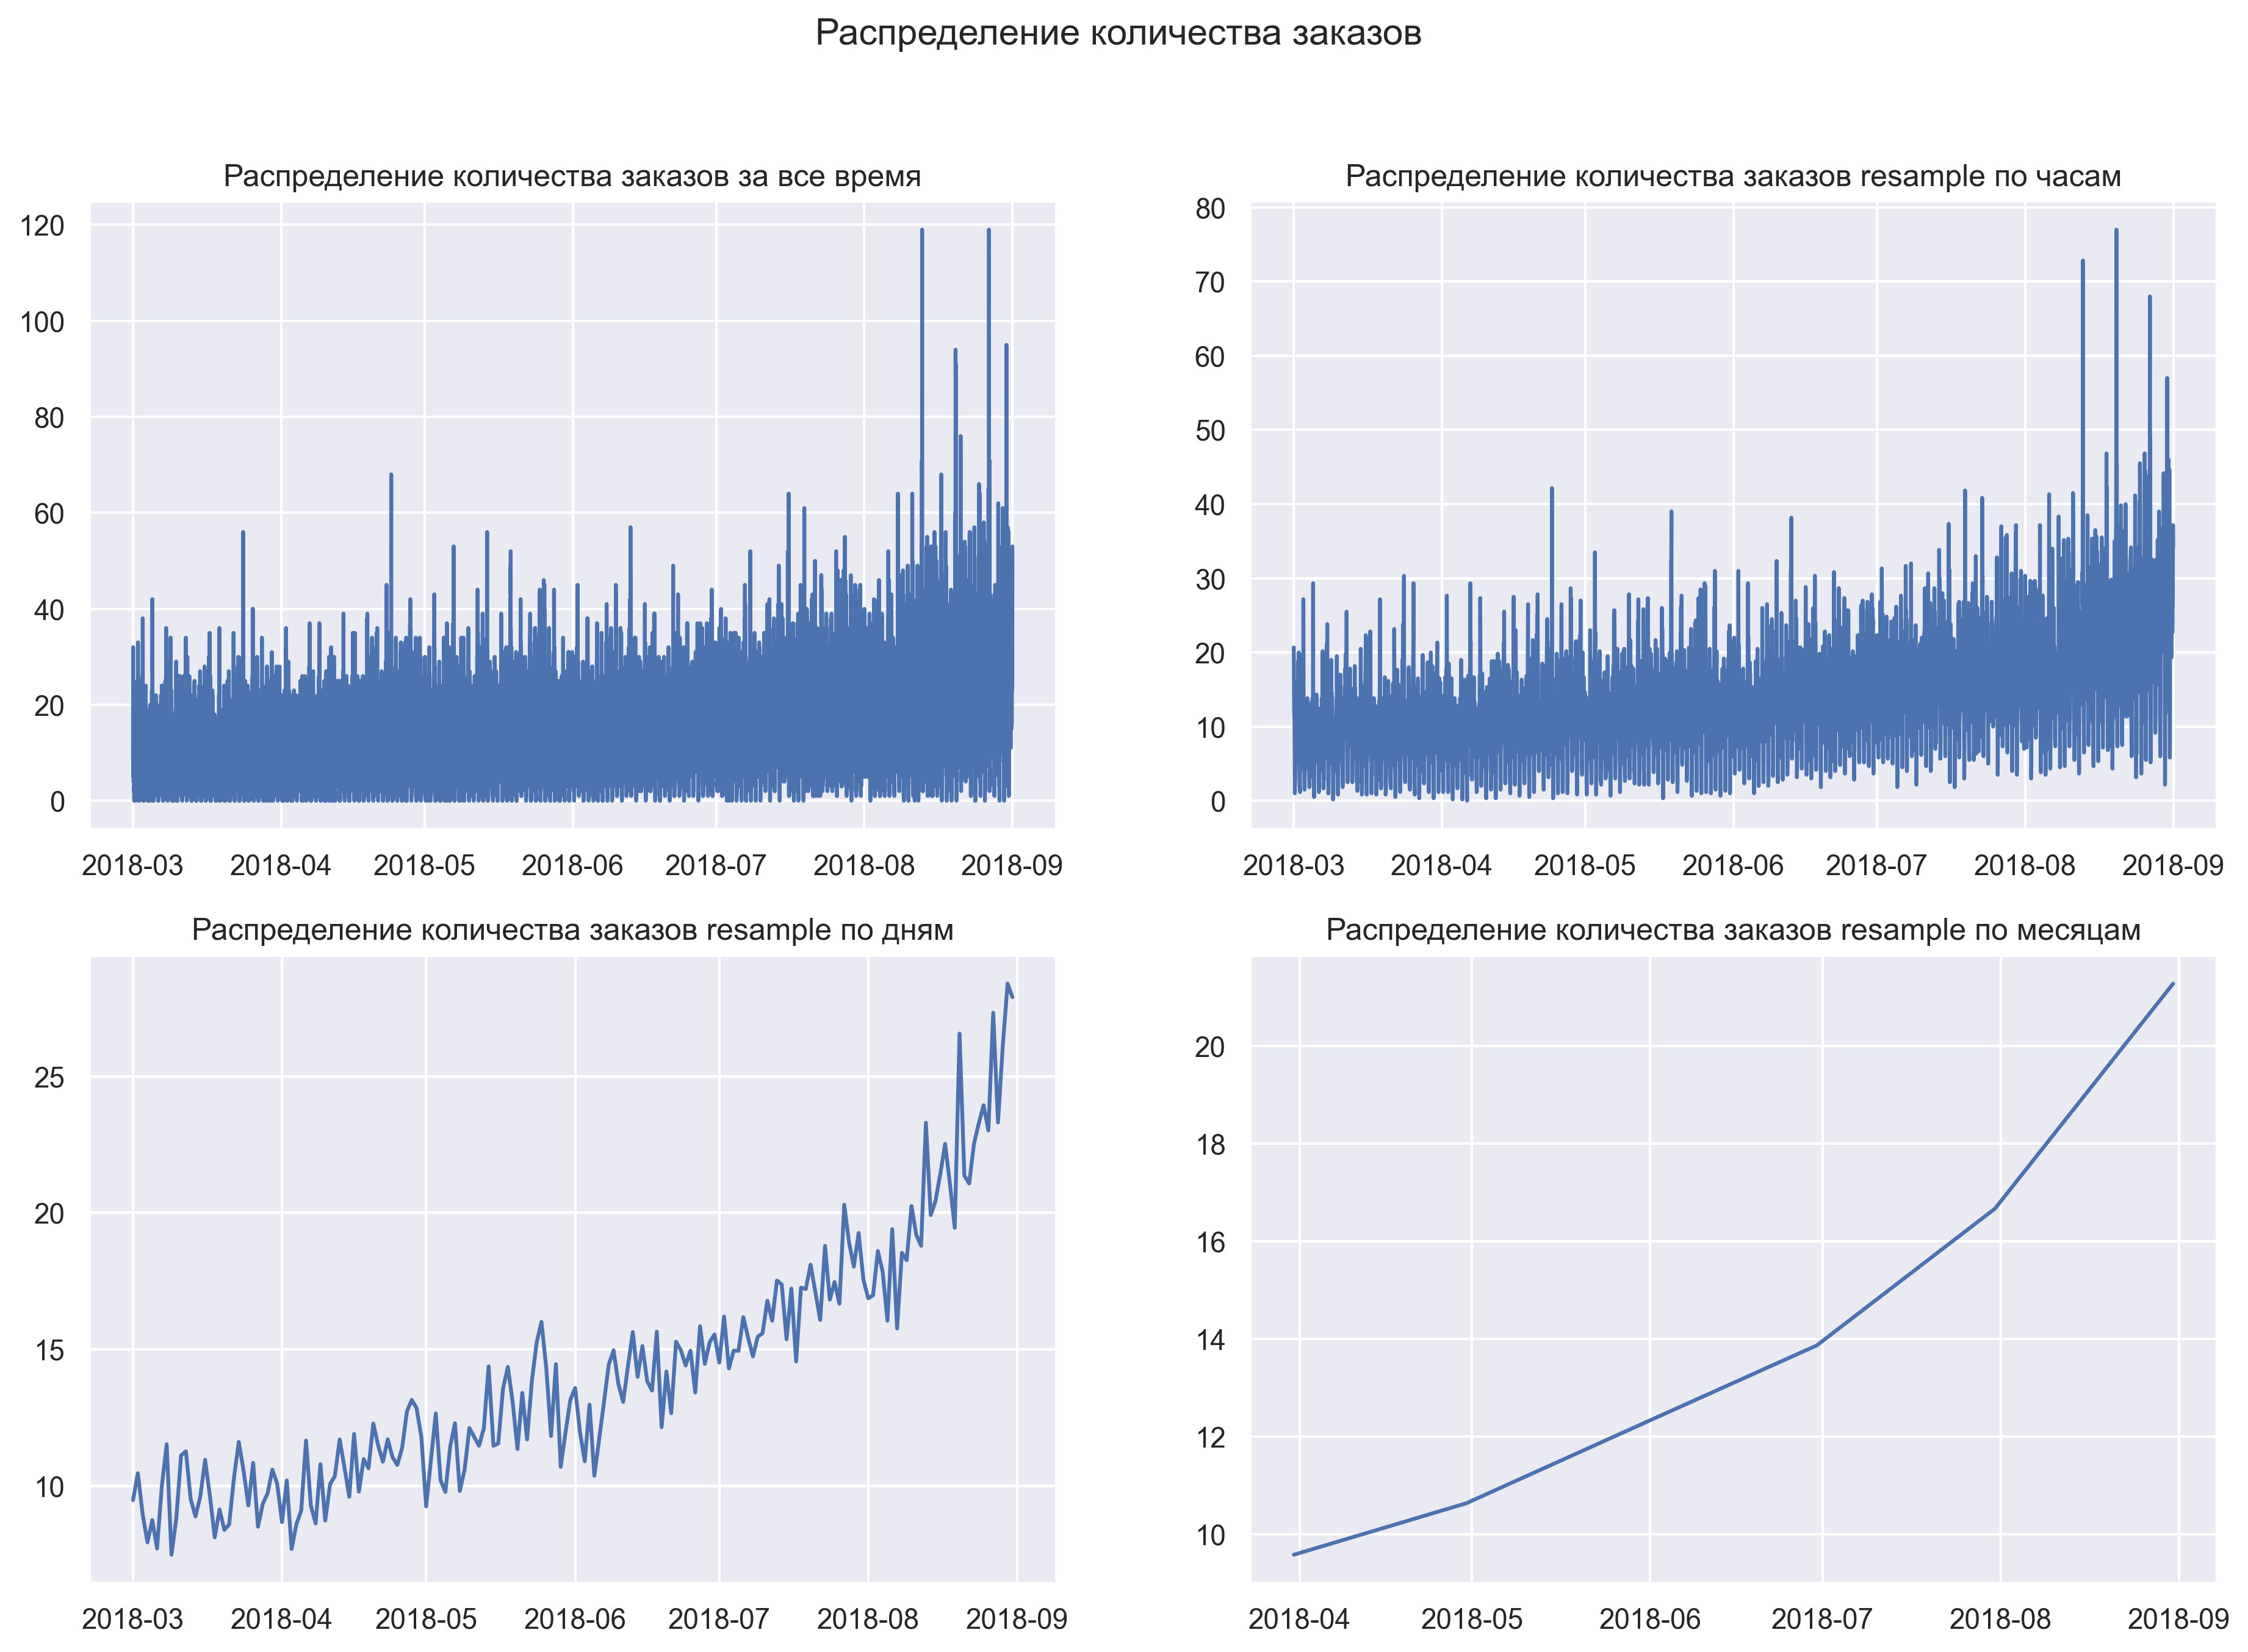

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10), dpi=300)
(ax1, ax2), (ax3, ax4) = axes
ax1.plot(data)
ax1.set_title('Распределение количества заказов за все время')
ax2.plot(data.resample('1H').mean())
ax2.set_title('Распределение количества заказов resample по часам')
ax3.plot(data.resample('1D').mean())
ax3.set_title('Распределение количества заказов resample по дням')
ax4.plot(data.resample('1M').mean())
ax4.set_title('Распределение количества заказов resample по месяцам')
fig.suptitle('Распределение количества заказов')

Можем отметить, что с марта по сентябрь среднее количество заказов такси росло

## Подготовка данных

Интервал измерений количества заказов в датасете составляет 10 минут, что слишком детально для наших целей. Выполним сэмплирование данных по часам методом `resample`. До и после преобразований выведем первые строки датасета для контроля

In [15]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [16]:
data = data.resample('1H').sum()

In [17]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Сформируем фунцкию создания признаков. На вход функции будет поступать датасет, максимальное количество сдвигов и размер скользящего среднего. На выходе формируется датасет со следующими дополнительными признаками: день недели, сдвиги(количество определяется входящим параметром), скользящее среднее  

In [18]:
def make_features(df, max_lag, rolling_mean_size):
    
    # День недели
    df['dayofweek'] = df.index.dayofweek
    
    # Сдвиг
    for lag in range(max_lag):
        df['lag_{0}'.format(lag+1)] = df['num_orders'].shift(lag+1)
    
    # Скользящее среднее
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # Разложим наш временной ряд на три составляющие: тренд, сезонность и остаток. 
    # Воспользуемся функцией seasonal_decompose() модуля tsa.seasonal библиотеки statsmodel
    # Создадим объект структуры decompose
    decomposed = seasonal_decompose(df['num_orders'])
    
    # Добавим информацию о тренде в датасет
    df['trend'] = decomposed.trend
        
    # Удалим объекты с пропусками
    df = df.dropna()
    
    # Создадим выборки признаков и целевого признака
    features = df.drop('num_orders', axis=1)
    target = df[['num_orders']]
    
    # Разделим выборки на обучающую и тестовую
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, shuffle=False, test_size=0.1, random_state=12345)

    return df, features_train, features_test, target_train, target_test

Создадим функцию для отображения формы датасета и его подвыборок

In [19]:
def shape(data, features_train, features_test, target_train, target_test):
    print('Форма всего датасета: {0}\n'.format(data.shape))
    print('{0:*^50}'.format('Форма выборок'))
    print('Признаки обучающих данных: {0}'.format(features_train.shape))
    print('Признаки тестовых данных: {0}'.format(features_test.shape))
    print('Целевой признак обучающих данных: {0}'.format(target_train.shape))
    print('Целевой признак тестовых данных: {0}'.format(target_test.shape))

**Проверим работу функций**

Создадим копию датасета

In [20]:
data1 = data.copy()

Вызовем функцию `make_features`, передав произвольное количество сдвигов и размер скользящего среднего

In [21]:
data1, features_train, features_test, target_train, target_test = make_features(data1, 40, 50)

Отобразим формы полученных переменных

In [22]:
shape(data1, features_train, features_test, target_train, target_test)

Форма всего датасета: (4354, 44)

******************Форма выборок*******************
Признаки обучающих данных: (3918, 43)
Признаки тестовых данных: (436, 43)
Целевой признак обучающих данных: (3918, 1)
Целевой признак тестовых данных: (436, 1)


Отобразим первые пять строк

In [23]:
data1.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,rolling_mean,trend
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,5,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,64.00,62.82,63.85
2018-03-03 03:00:00,64,5,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,60.84,64.15
2018-03-03 04:00:00,44,5,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,60.42,63.75
2018-03-03 05:00:00,15,5,44.00,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,59.88,62.29
2018-03-03 06:00:00,9,5,15.00,44.00,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,58.86,61.15


## Анализ

Построим графики распределения с составляющими временного ряда

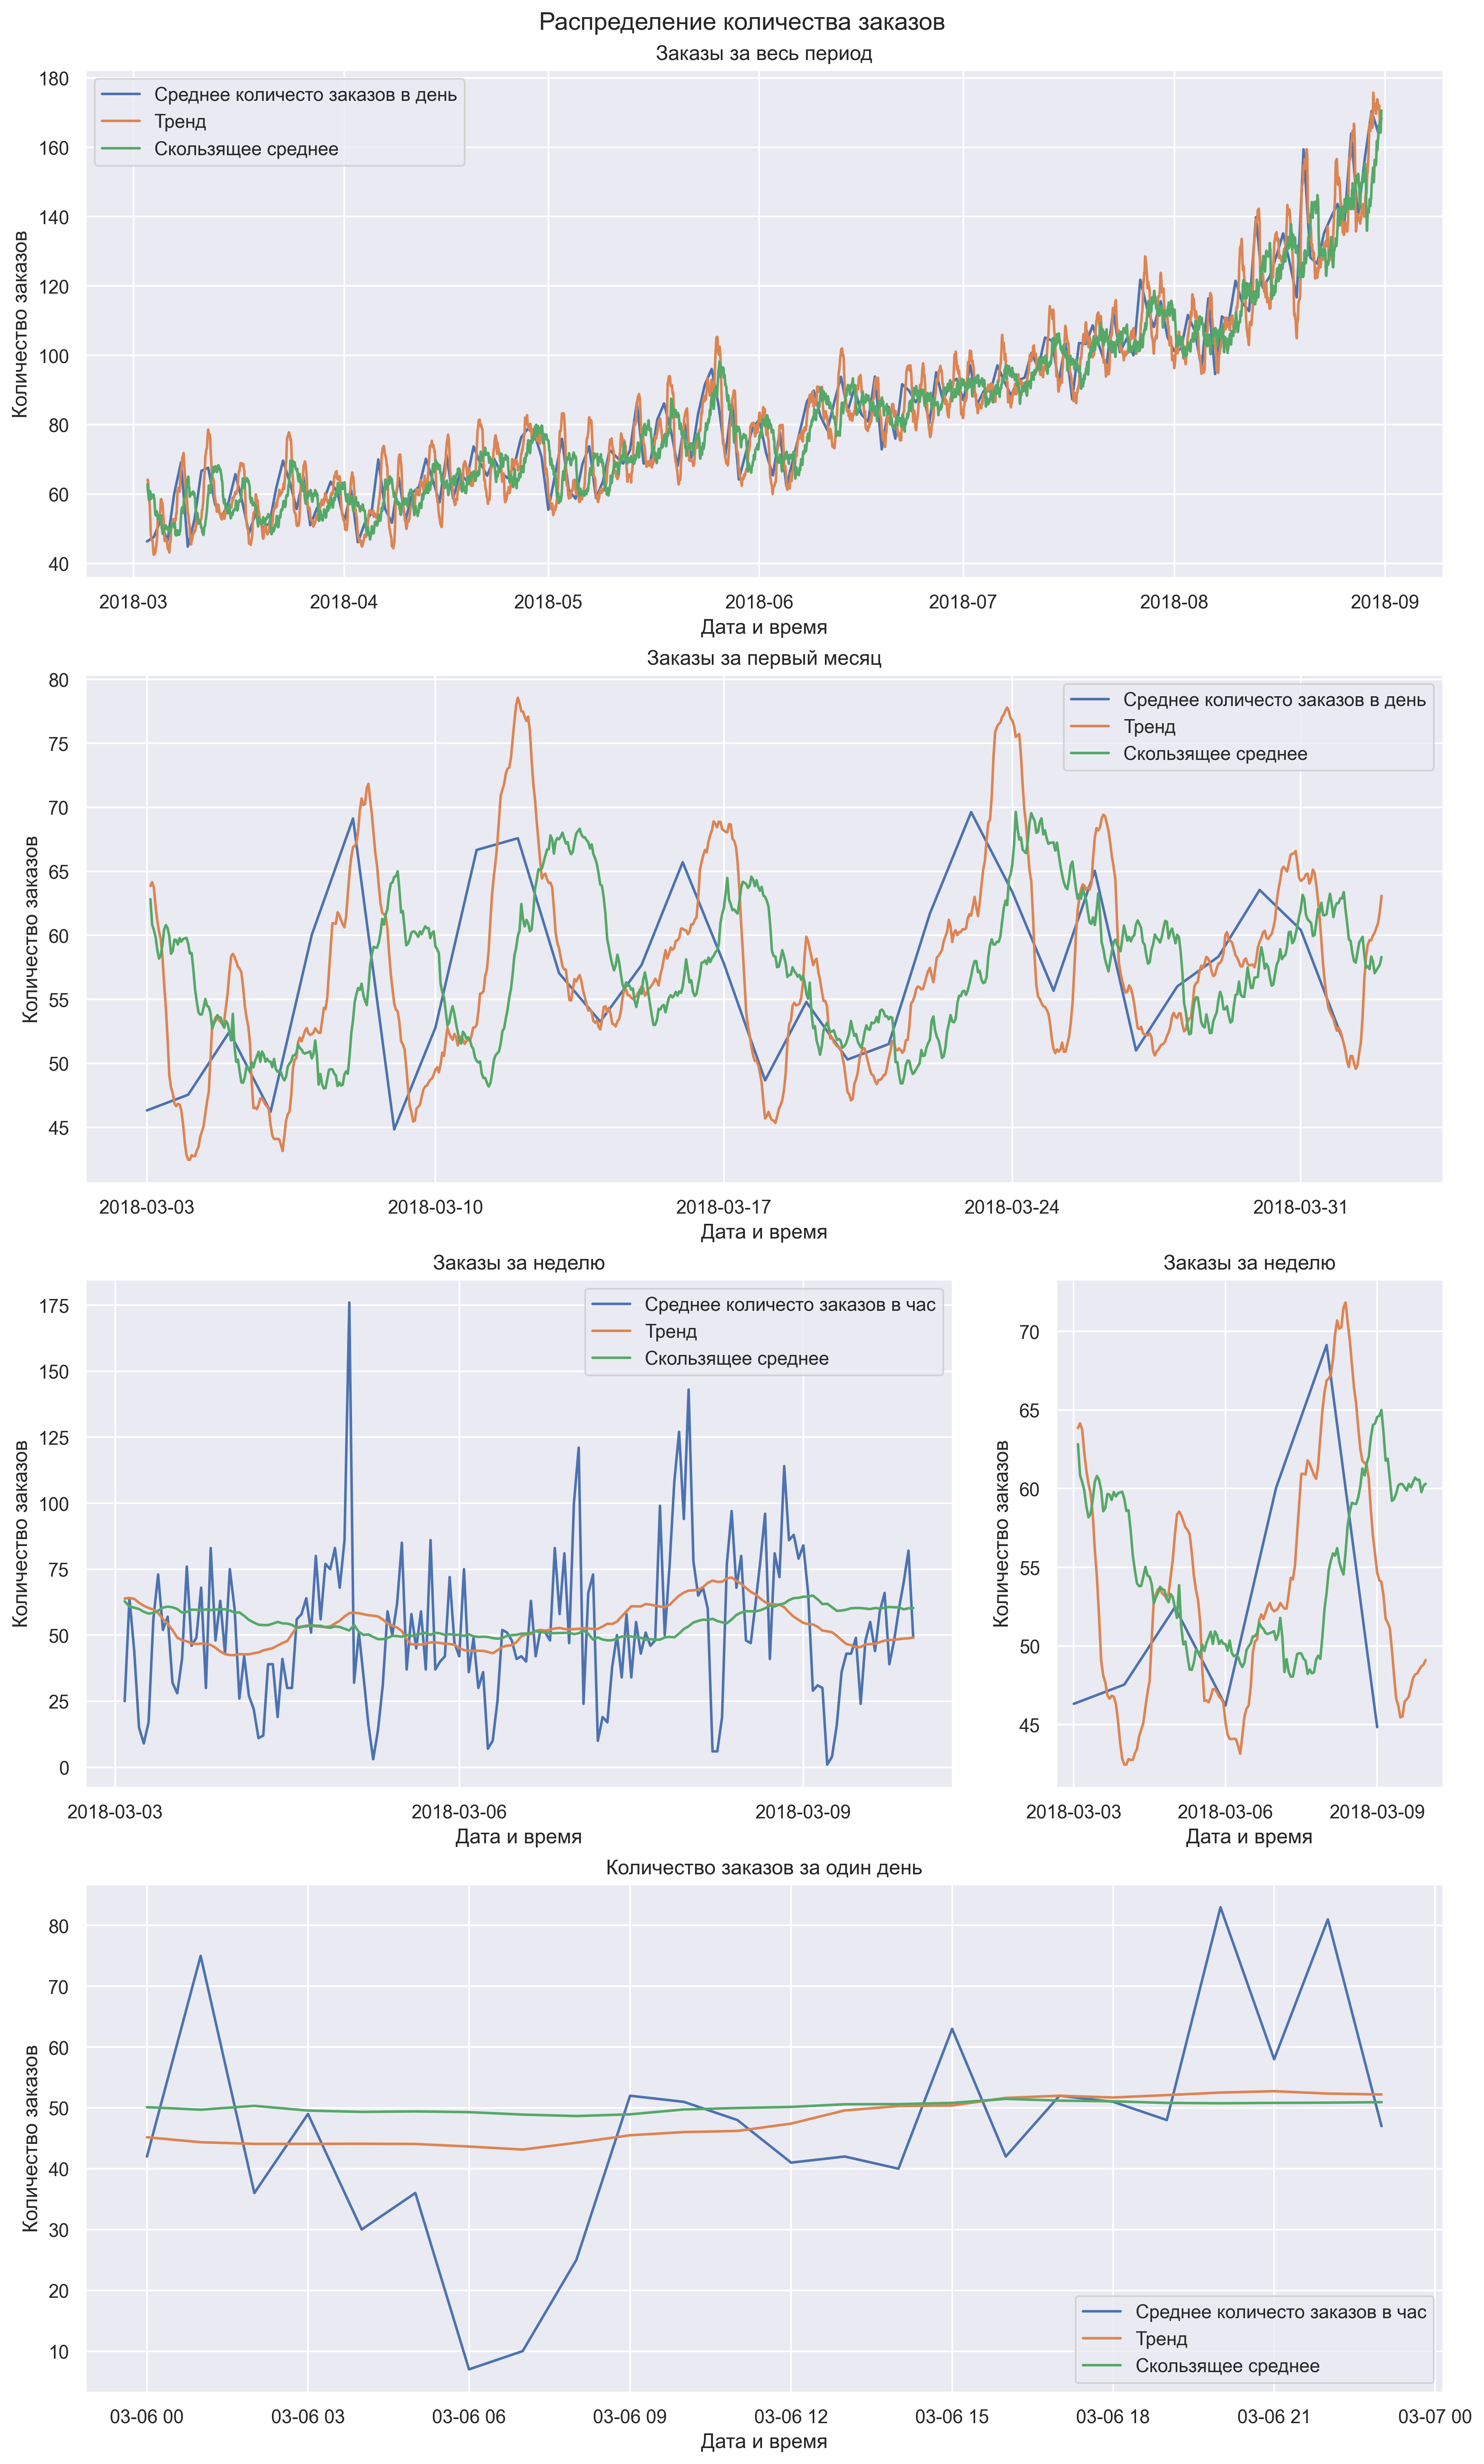

In [24]:
fig = plt.figure(figsize=(12,20), constrained_layout=True, dpi=300)

gs = GridSpec(4, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(data1['num_orders'].resample('1D').mean(), label='Cреднее количесто заказов в день')
ax1.plot(data1['trend'], label='Тренд')
ax1.plot(data1['rolling_mean'], label='Скользящее среднее', color='g')
ax1.legend()
ax1.set_xlabel('Дата и время')
ax1.set_ylabel('Количество заказов')
ax1.set_title('Заказы за весь период')

ax2 = fig.add_subplot(gs[1, :])
ax2.plot(data1.loc[:'2018-04-01','num_orders'].resample('1D').mean(), label='Cреднее количесто заказов в день')
ax2.plot(data1.loc[:'2018-04-01','trend'], label='Тренд')
ax2.plot(data1.loc[:'2018-04-01', 'rolling_mean'], label='Скользящее среднее', color='g')
ax2.legend()
ax2.set_title('Заказы за первый месяц')
ax2.set_xticks(list(data1.loc[:'2018-04-01','num_orders'].resample('7D').mean().index))
ax2.set_xlabel('Дата и время')
ax2.set_ylabel('Количество заказов')

ax3 = fig.add_subplot(gs[2, :-1])
ax3.plot(data1.loc['2018-03-03':'2018-03-09','num_orders'], label='Cреднее количесто заказов в час')
ax3.plot(data1.loc['2018-03-03':'2018-03-09','trend'], label='Тренд')
ax3.plot(data1.loc['2018-03-03':'2018-03-09', 'rolling_mean'], label='Скользящее среднее', color='g')
ax3.legend()
ax3.set_title('Заказы за неделю')
ax3.set_xticks(['2018-03-03', '2018-03-06', '2018-03-09'])
ax3.set_xlabel('Дата и время')
ax3.set_ylabel('Количество заказов')

ax4 = fig.add_subplot(gs[2, -1])
ax4.plot(data1.loc['2018-03-03':'2018-03-09','num_orders'].resample('1D').mean(), label='Cреднее количесто заказов в день')
ax4.plot(data1.loc['2018-03-03':'2018-03-09','trend'], label='Тренд')
ax4.plot(data1.loc['2018-03-03':'2018-03-09', 'rolling_mean'], label='Скользящее среднее', color='g')

ax4.set_title('Заказы за неделю')
ax4.set_xticks(['2018-03-03', '2018-03-06', '2018-03-09'])
ax4.set_xlabel('Дата и время')
ax4.set_ylabel('Количество заказов')

ax5 = fig.add_subplot(gs[3, :])
ax5.plot(data1.loc['2018-03-06 00:00:00':'2018-03-06 23:00:00','num_orders'], label='Cреднее количесто заказов в час')
ax5.plot(data1.loc['2018-03-06 00:00:00':'2018-03-06 23:00:00','trend'], label='Тренд')
ax5.plot(data1.loc['2018-03-06 00:00:00':'2018-03-06 23:00:00', 'rolling_mean'], label='Скользящее среднее', color='g')
ax5.legend()
ax5.set_title('Количество заказов за один день')
ax5.set_xlabel('Дата и время')
ax5.set_ylabel('Количество заказов')

fig.suptitle("Распределение количества заказов")

plt.show()

**Промежуточные выводы**
- Сезонная составляющая и остаток не представлены на графиках, так как датасет содержит данные только за 6 месяцев
- Графики среднего скользящего и тренада в целом повторяют распределение количества заказов в семплировании по дням 

## Обучение

Обучим модели линейной регрессии, случайного леса, градиентного бустинга (CatBoost).
На модели линейной регрессии подберем оптимальные размер скользящего среднего и количество сдвигов

Создадим списки, в которые будем записывать качество предсказаний моделей

In [25]:
rmse_train = []
rmse_test = []

### Кросс-валидация

Создадим объект `TimeSeriesSplit` для кросс-валидации, имеющегося временного ряда. Данный метод позволяет разбить данные таким образом, чтобы тестовая выборка всегда оказывалась правее на временной оси. С каждой новой итерацией разбиения объекты таргета предыдущей итерации дополняют обучающую выборку

In [26]:
ts_cv = TimeSeriesSplit(n_splits=8)

Создадим список разбиений

In [27]:
all_splits = list(ts_cv.split(features_train, target_train))

Проверим, что разделение прошло успешно. Создадим переменные, содержащие индексы объектов на соответствующей итерации

In [28]:
train_0, test_0 = all_splits[0]

Отобразим признаки объектов первой итерации разбиения 

In [29]:
features_train.iloc[train_0]

,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,rolling_mean,trend
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,5,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,64.00,62.82,63.85
2018-03-03 03:00:00,5,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,60.84,64.15
2018-03-03 04:00:00,5,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,60.42,63.75
2018-03-03 05:00:00,5,44.00,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,59.88,62.29
2018-03-03 06:00:00,5,15.00,44.00,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,58.86,61.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21 03:00:00,2,35.00,85.00,71.00,69.00,55.00,47.00,67.00,45.00,97.00,51.00,75.00,74.00,29.00,44.00,30.00,43.00,58.00,53.00,30.00,14.00,7.00,5.00,43.00,50.00,39.00,100.00,82.00,84.00,66.00,39.00,56.00,34.00,57.00,65.00,44.00,48.00,50.00,45.00,39.00,83.00,52.32,51.73
2018-03-21 04:00:00,2,51.00,35.00,85.00,71.00,69.00,55.00,47.00,67.00,45.00,97.00,51.00,75.00,74.00,29.00,44.00,30.00,43.00,58.00,53.00,30.00,14.00,7.00,5.00,43.00,50.00,39.00,100.00,82.00,84.00,66.00,39.00,56.00,34.00,57.00,65.00,44.00,48.00,50.00,45.00,39.00,50.08,51.08
2018-03-21 05:00:00,2,21.00,51.00,35.00,85.00,71.00,69.00,55.00,47.00,67.00,45.00,97.00,51.00,75.00,74.00,29.00,44.00,30.00,43.00,58.00,53.00,30.00,14.00,7.00,5.00,43.00,50.00,39.00,100.00,82.00,84.00,66.00,39.00,56.00,34.00,57.00,65.00,44.00,48.00,50.00,45.00,50.10,51.00


Отобразим целевой признак объектов первой итерации разбиения 

In [30]:
target_train.iloc[test_0]

,num_orders
datetime,
2018-03-21 08:00:00,39
2018-03-21 09:00:00,56
2018-03-21 10:00:00,57
2018-03-21 11:00:00,71
2018-03-21 12:00:00,37
...,...
2018-04-08 06:00:00,7
2018-04-08 07:00:00,8
2018-04-08 08:00:00,52


Тестовые данные действительно позднее, чем обучающие

Сделаем тоже самое для последней итерации

 Создадим переменные, содержащие индексы объектов на соответствующей итерации

In [31]:
train_4, test_4 = all_splits[4]

Отобразим признаки объектов первой итерации разбиения 

In [32]:
features_train.iloc[train_4]

,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,rolling_mean,trend
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,5,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,64.00,62.82,63.85
2018-03-03 03:00:00,5,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,60.84,64.15
2018-03-03 04:00:00,5,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,60.42,63.75
2018-03-03 05:00:00,5,44.00,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,59.88,62.29
2018-03-03 06:00:00,5,15.00,44.00,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,58.86,61.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-01 15:00:00,4,48.00,85.00,69.00,124.00,93.00,92.00,115.00,27.00,22.00,50.00,65.00,132.00,111.00,77.00,118.00,129.00,93.00,107.00,75.00,62.00,36.00,80.00,101.00,71.00,77.00,70.00,65.00,88.00,73.00,91.00,71.00,17.00,6.00,48.00,142.00,92.00,101.00,61.00,137.00,85.00,81.02,84.40
2018-06-01 16:00:00,4,46.00,48.00,85.00,69.00,124.00,93.00,92.00,115.00,27.00,22.00,50.00,65.00,132.00,111.00,77.00,118.00,129.00,93.00,107.00,75.00,62.00,36.00,80.00,101.00,71.00,77.00,70.00,65.00,88.00,73.00,91.00,71.00,17.00,6.00,48.00,142.00,92.00,101.00,61.00,137.00,80.16,84.04
2018-06-01 17:00:00,4,72.00,46.00,48.00,85.00,69.00,124.00,93.00,92.00,115.00,27.00,22.00,50.00,65.00,132.00,111.00,77.00,118.00,129.00,93.00,107.00,75.00,62.00,36.00,80.00,101.00,71.00,77.00,70.00,65.00,88.00,73.00,91.00,71.00,17.00,6.00,48.00,142.00,92.00,101.00,61.00,80.48,84.54


Отобразим целевой признак объектов первой итерации разбиения

In [33]:
target_train.iloc[test_4]

,num_orders
datetime,
2018-06-01 20:00:00,73
2018-06-01 21:00:00,106
2018-06-01 22:00:00,124
2018-06-01 23:00:00,100
2018-06-02 00:00:00,186
...,...
2018-06-19 18:00:00,82
2018-06-19 19:00:00,47
2018-06-19 20:00:00,57


Видим, что обучающая выборка увеличилась, а тестовые данные все также наиболее поздние

### Формирование функции потерь

Запишем фунцию потерь. Функция будет рассчитывать квадратный корень из средне-квадратической ошибки (RMSE)

In [34]:
def loss_func(y_true, y_pred):
    rmse = mse(y_true, y_pred) ** 0.5
    return rmse

Сформируем оценщик

In [35]:
score = make_scorer(loss_func, greater_is_better=False)

### Линейная регрессия

Создадим модель

In [36]:
lr = LinearRegression()

Подберем оптимальные размер скользящего среднего и количество сдвигов.

In [37]:
%%time

# Создадим переменные, в которых будет содержаться оптимальные параметры
best_shift_num = 0
best_roll_size = 0
best_score = 100

# Внешний цикл перебирает количество сдвигов
for shift in range(1, 50):
    
    # Внутренний цикл перебирает размер среднего скользящего
    for roll in range(5, 100, 5):
        
        # Создадим копию датасета
        data_copy = data.copy()
        
        # Преобразуем датасет с помощью функции make_features
        data_copy, features_train, features_test, target_train, target_test = make_features(data_copy, shift, roll)
        
        # Оценим качество модели при данных параметрах датасета
        cvs = np.abs(cross_val_score(lr, features_train, target_train, scoring=score, cv=ts_cv).mean())

        # Обновим оптимальные параметры, если качество модели лучше, чем было ранее. 
        if cvs < best_score:
            best_score = cvs
            best_roll_size = roll
            best_shift_num = shift

Wall time: 1min 31s


Отразим результаты

In [38]:
print(
    'Количество сдвигов: {0}\nРазмер скользящего среднего: {1}\nRMSE модели: {2:.3f}'.format(
    best_shift_num, best_roll_size, best_score))    

Количество сдвигов: 49
Размер скользящего среднего: 70
RMSE модели: 22.611


Создадим датафрейм с оптимальными параметрами

In [39]:
transformed_data, features_train, features_test, target_train, target_test = make_features(data, 48, 70)

Оценим качество на обучающих данных

In [40]:
# Обучим модель
lr.fit(features_train, target_train)
# Сделаем предсказание
lr_pred_train = lr.predict(features_train)
# Отобразим качество
print('RMSE обучающих данных: {0:.3f}'.format(loss_func(target_train, lr_pred_train)))

RMSE обучающих данных: 21.854


Добавим оценку качества в соответствующий список

In [41]:
rmse_train.append(loss_func(target_train, lr_pred_train))

### Случайный лес

Зададим модель случайный лес

In [42]:
rfr = RandomForestRegressor(random_state=12345, bootstrap = False)

Подберем гиперпараметры методом `RandomizedSearchCV` из библиотеки `sklearn.model_selection`

In [43]:
%%time
# Зададим параметры, среди которых необходимо найти лучшую комбинацию
# метод np.linspace позволяет установить интервал и количество точек в нем,
# которые нужно перебрать
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 15)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]

# Создадим словарь гиперпараметров
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Зададим RandomizedSearchCV
rs_rfr = RandomizedSearchCV(rfr, 
                        param_dist, 
                        n_iter = 100, 
                        cv = ts_cv, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0,
                        scoring=score)

# Обучим RandomizedSearchCV
rs_rfr.fit(features_train, target_train.values.ravel())

Fitting 8 folds for each of 100 candidates, totalling 800 fits
Wall time: 31.2 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                   estimator=RandomForestRegressor(bootstrap=False,
                                                   random_state=12345),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 7, 12, 18, 23,
                                                             28, 34, 39, 44,
                                                             50],
                                        'min_samples_split': [2, 7, 12, 18, 23,
                                                              28, 34, 39, 44,
                                                              50],
                                        'n

Выведем лучшие параметры модели

In [44]:
print('Лучшие параметры: {}'.format(rs_rfr.best_params_)) 
print('Лучшая оценка RMSE: {0:.3f}'.format(np.abs(rs_rfr.best_score_)))

Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 23, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}
Лучшая оценка RMSE: 23.666


Сохраним модель с лучшими параметрами в перенную

In [45]:
rs_rfr_best = rs_rfr.best_estimator_

Оценим качество предсказания на обучающих данных

In [46]:
rs_rfr_best_pred_train = rs_rfr_best.predict(features_train)
print('RMSE обучающих данных: {0:.3f}'.format(loss_func(target_train, rs_rfr_best_pred_train)))

RMSE обучающих данных: 12.462


Добавим оценку качества в соответствующий список

In [47]:
rmse_train.append(loss_func(target_train, rs_rfr_best_pred_train))

**Оценим значимость признаков**

Создадим список названий признаков

In [48]:
feature_names = features_train.columns

Создадим датафрейм важности признаков

In [49]:
rs_feature_importances = (pd.DataFrame(data={'feature_id': feature_names, 'importances': rs_rfr_best.feature_importances_})
                           .sort_values(by='importances',ascending=False)
                           .reset_index(drop=True))

Отобразим первые 15 строк

In [50]:
rs_feature_importances.head(15)

,feature_id,importances
0,lag_48,0.22
1,lag_24,0.13
2,trend,0.09
3,lag_1,0.07
4,lag_47,0.05
5,lag_25,0.05
6,lag_23,0.04
7,lag_2,0.03
8,rolling_mean,0.03
9,lag_17,0.02


Отобразим графически

Text(0, 0.5, 'Признаки')

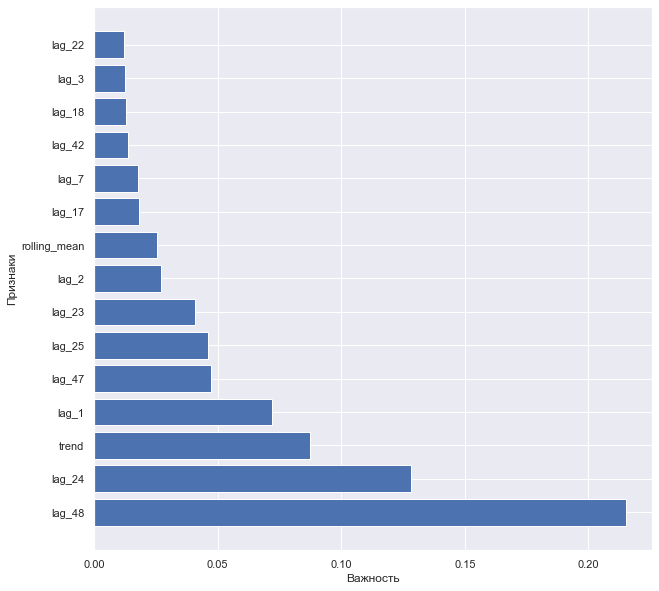

In [51]:
plt.figure(figsize=(10,10))
plt.barh(y=rs_feature_importances.head(15)['feature_id'], width=rs_feature_importances['importances'].head(15))
plt.xlabel('Важность')
plt.ylabel('Признаки')

### CatBoost

Создадим обучающий и тестовый пулы данных

In [52]:
train_pool = catboost.Pool(features_train, target_train, cat_features = ['dayofweek'])
test_pool = catboost.Pool(features_test, target_test, cat_features = ['dayofweek'])

Создадим модель

In [53]:
cbr = CatBoostRegressor(verbose = False)

Найдем гиперпараметры модели с помощью встроенного в CatBoost `randomized_search` 

In [54]:
%%time

# Зададим параметры, среди которых необходимо найти лучшую комбинацию
# метод np.linspace позволяет установить интервал и количество точек в нем,
# которые нужно перебрать
learning_rate = [0.01, 0.1, 0.3, 0.5 ]
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 20)]
depth = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]


# Создадим словарь гиперпараметров
param_dist = { 'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'depth': depth}

# Зададим RandomizedSearch
cbr_rs = cbr.randomized_search(
                            param_dist,
                            train_pool,
                            n_iter = 10,
                            cv = ts_cv,
                            verbose = False,
                            shuffle=False,
                            plot=True
                           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 77.62365614
bestIteration = 5


bestTest = 106.8694727
bestIteration = 10


bestTest = 33.79969164
bestIteration = 11


bestTest = 33.79969164
bestIteration = 11


bestTest = 74.01033996
bestIteration = 72


bestTest = 32.60290321
bestIteration = 36


bestTest = 49.97171502
bestIteration = 15


bestTest = 36.49749516
bestIteration = 36


bestTest = 34.09279478
bestIteration = 88


bestTest = 34.06648648
bestIteration = 19

Training on fold [0/8]

bestTest = 18.6512211
bestIteration = 38

Training on fold [1/8]

bestTest = 20.71135643
bestIteration = 26

Training on fold [2/8]

bestTest = 20.95681789
bestIteration = 45

Training on fold [3/8]

bestTest = 22.068052
bestIteration = 61

Training on fold [4/8]

bestTest = 21.5214693
bestIteration = 75

Training on fold [5/8]

bestTest = 22.56751458
bestIteration = 78

Training on fold [6/8]

bestTest = 26.90148999
bestIteration = 72

Training on fold [7/8]

bestTest = 31.24856572
bestIteration = 71

Wall time: 13.3 s


Отобразим наиболее оптимальные параметры и присвоим их модели

In [55]:
print(cbr_rs['params'])

{'depth': 3, 'iterations': 79, 'learning_rate': 0.3}


Оценим качество предсказания на обучающих данных

In [56]:
cbr_train_pred = cbr.predict(features_train)
print('RMSE обучающих данных: {0:.3f}'.format(loss_func(target_train, cbr_train_pred)))

RMSE обучающих данных: 18.985


Добавим оценку качества в соответствующий список

In [57]:
rmse_train.append(loss_func(target_train, lr_pred_train))

**Оценим значимость признаков**

Инструмент `randomized_search` автоматически присвоил нашей модели лучшие параметры.

Создадим датафрейм важности признаков. Воспользуемся инструментом `get_feature_importance`. Параметр `prettified` позволяет автоматически сформировать датафрейм

In [58]:
cbr_feature_importances = cbr.get_feature_importance(train_pool, prettified=True)

Отобразим первые 15 строк

In [59]:
cbr_best = CatBoostRegressor(depth=3, iterations=79, learning_rate=0.3).fit(train_pool,verbose=False)

In [60]:
cbr_feature_importances.head(15)

,Feature Id,Importances
0,lag_48,27.29
1,lag_24,19.32
2,trend,14.93
3,lag_1,11.69
4,lag_17,2.46
5,lag_2,1.89
6,lag_23,1.66
7,lag_41,1.32
8,lag_42,1.09
9,lag_38,0.94


Отобразим графически

Text(0, 0.5, 'Признаки')

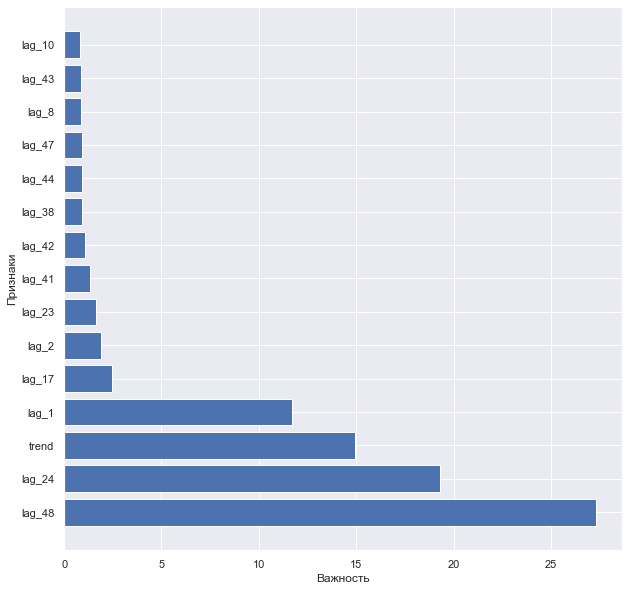

In [61]:
plt.figure(figsize=(10,10))
plt.barh(cbr_feature_importances.head(15)['Feature Id'], cbr_feature_importances['Importances'].head(15))
plt.xlabel('Важность')
plt.ylabel('Признаки')

## Тестирование

Проверим качество предсказаний наших моделей на тестовых данных

**Линейная регрессия**

In [62]:
lr_pred_test = lr.predict(features_test)
print('RMSE тестовых данных: {0:.3f}'.format(loss_func(target_test, lr_pred_test)))

rmse_test.append(loss_func(target_test, lr_pred_test))

RMSE тестовых данных: 39.419


**Случайный лес**

In [63]:
rs_rfr_best_pred_test = rs_rfr_best.predict(features_test)
print('RMSE тестовых данных: {0:.3f}'.format(loss_func(target_test, rs_rfr_best_pred_test)))
rmse_test.append(loss_func(target_test, rs_rfr_best_pred_test))

RMSE тестовых данных: 39.645


**CatBoost**

In [64]:
cbr_rs_best_pred_test = cbr.predict(features_test)
print('RMSE тестовых данных: {0:.3f}'.format(loss_func(target_test, cbr_rs_best_pred_test)))
rmse_test.append(loss_func(target_test, cbr_rs_best_pred_test))

RMSE тестовых данных: 42.121


**Сводная таблица**

In [65]:
pd.DataFrame(data={'rmse_train':rmse_train, 'rmse_test':rmse_test}, index=['linear', 'randome_forest', 'catboost'])

,rmse_train,rmse_test
linear,21.85,39.42
randome_forest,12.46,39.65
catboost,21.85,42.12


**Графическое представление результатов прогноза**

Создадим датафрейм с предсказаниями модели CatBoost. В качестве индексов используем индексы целевого признака тестовой выворки

In [66]:
pred_test = pd.DataFrame(data={'num_orders_pred':cbr_rs_best_pred_test}, index=target_test.index)

Построим график предсказаний на два дня

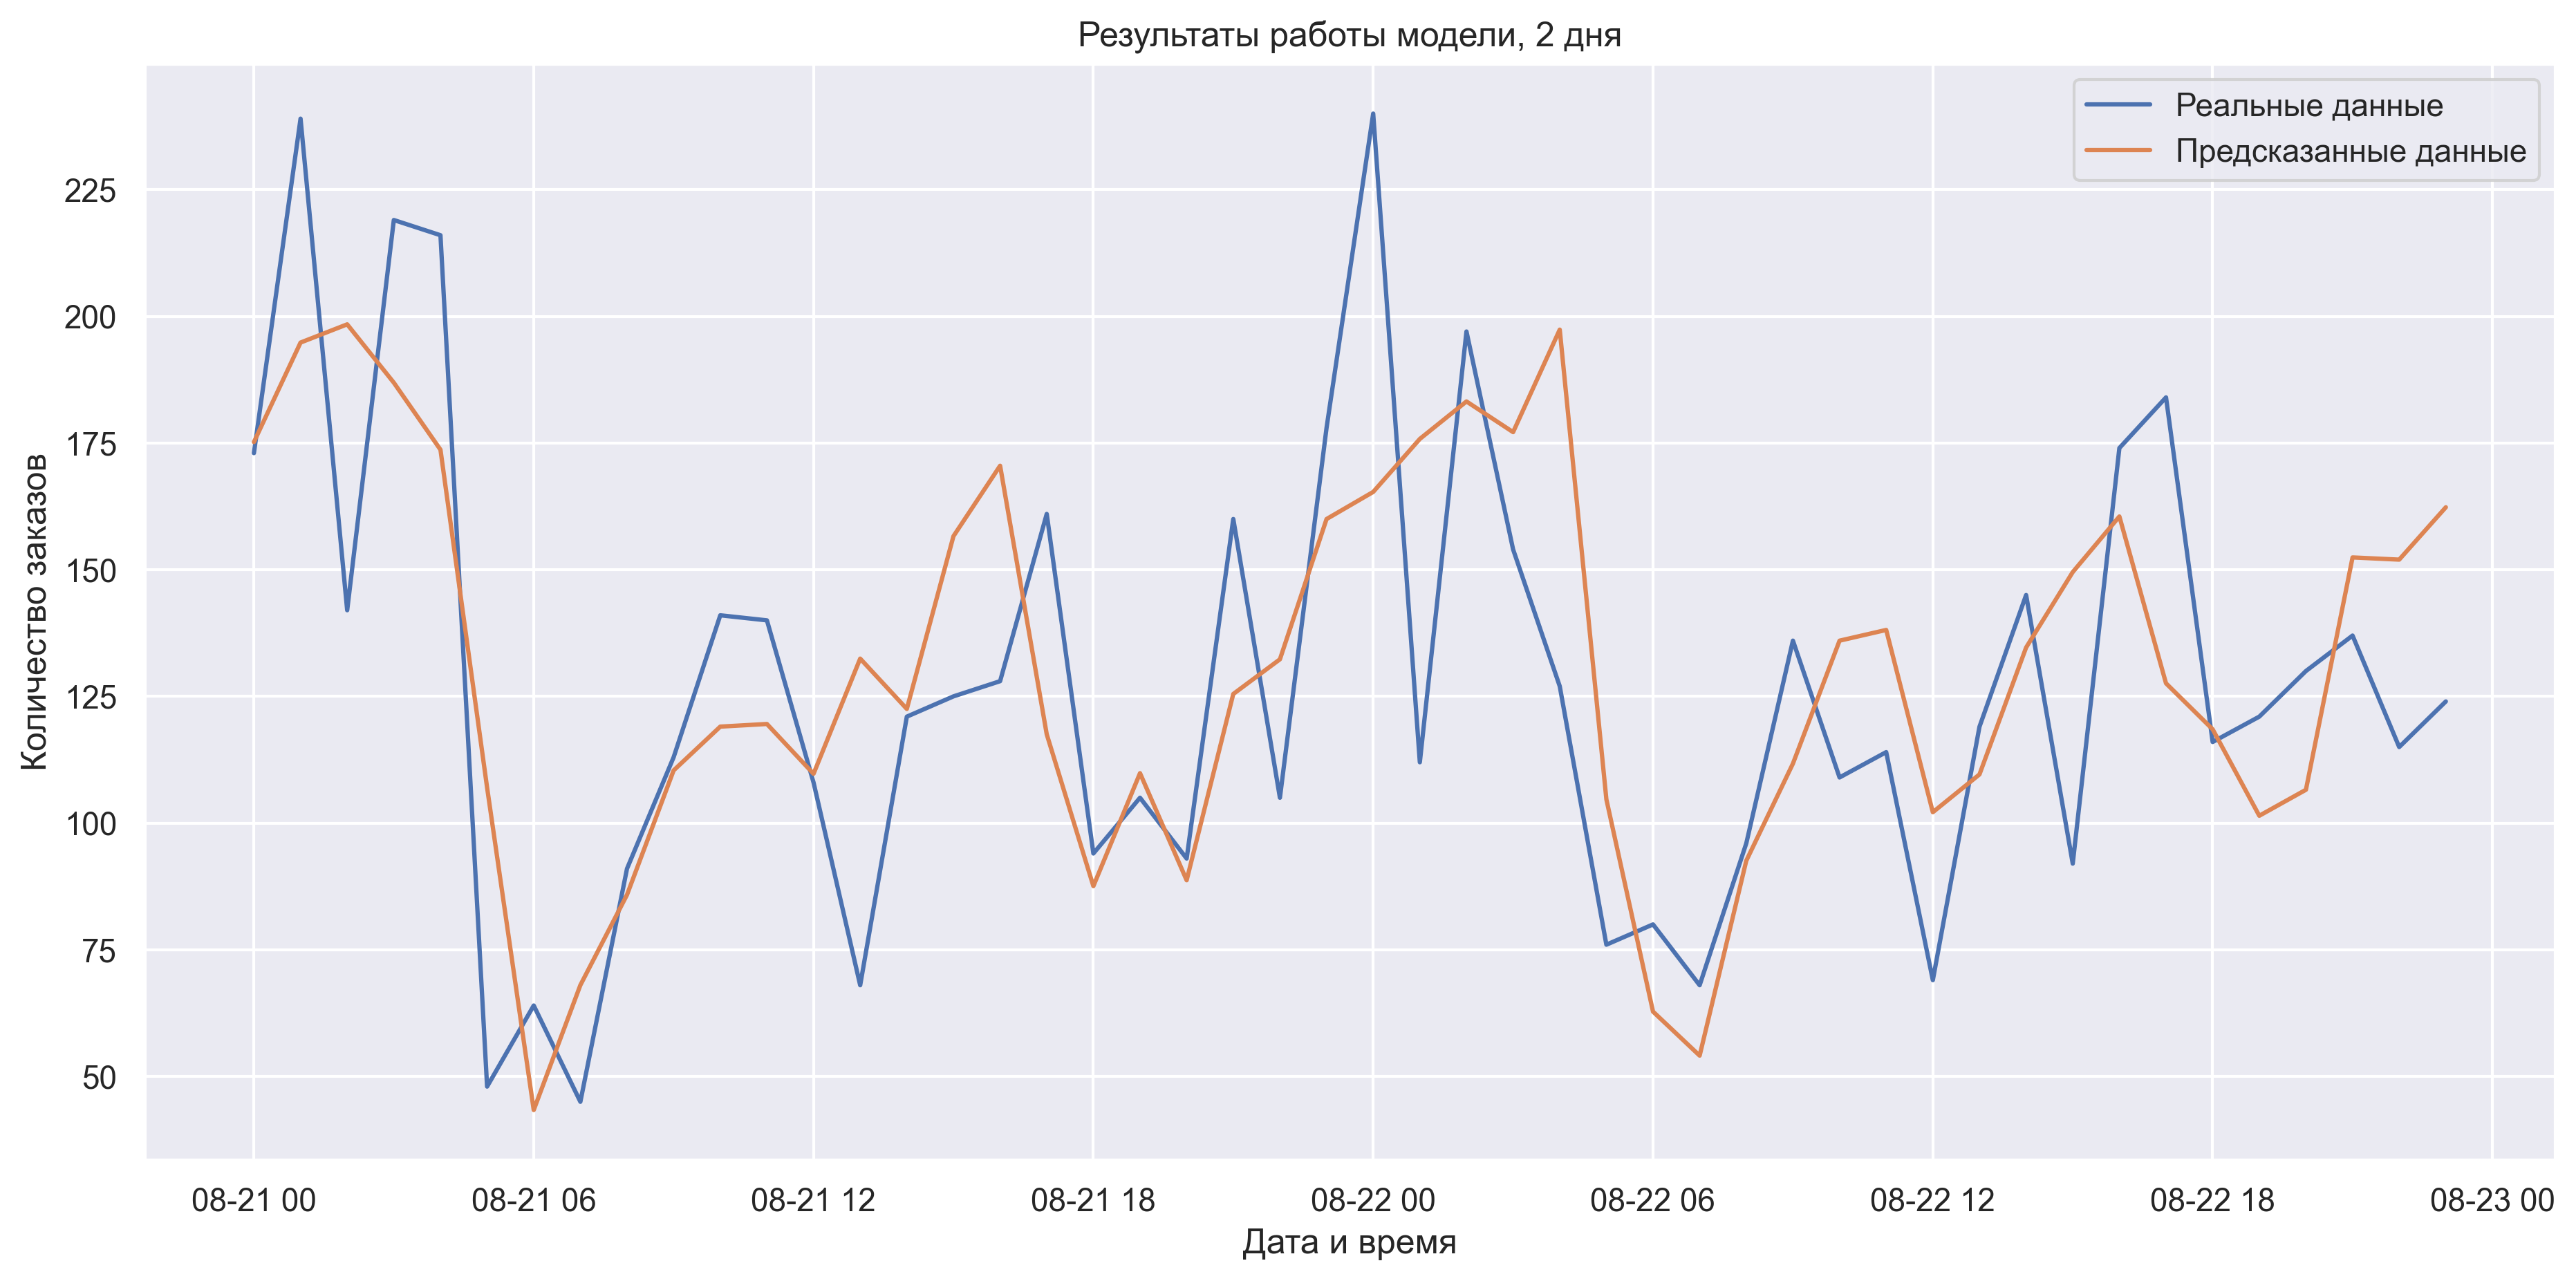

In [67]:
plt.figure(figsize=(15,7), dpi=300)
plt.plot(target_test['2018-08-21':'2018-08-22'], label='Реальные данные')
plt.plot(pred_test['2018-08-21':'2018-08-22'], label='Предсказанные данные')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.title('Результаты работы модели, 2 дня')
plt.legend()

**Выводы**
- Все выбранные модели дали качественный результат предсказания
- Лучшей моделью прогноза количества заказов такси стала модель линейной регрессии